In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

sns.set_style('whitegrid')

## EDA

In [42]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [71]:
grouped = df.groupby('Rating')['Rating'].count()
grouped

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating'>

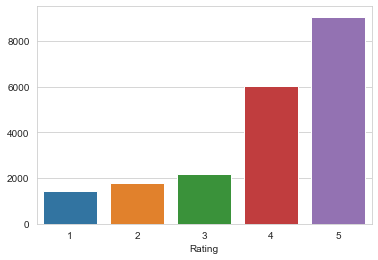

In [50]:
sns.barplot(x = grouped.index, y = grouped.values)

In [69]:
df['words'] = [x.split() for x in df['Review']]

df['word_count'] = [len(x) for x in df['words']]

In [70]:
df.head()

,Review,Rating,word_count,words
0,nice hotel expensive parking got good deal sta...,4,87,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,250,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,3,217,"[nice, rooms, not, 4*, experience, hotel, mona..."
3,"unique, great stay, wonderful time hotel monac...",5,89,"[unique,, great, stay,, wonderful, time, hotel..."
4,"great stay great stay, went seahawk game aweso...",5,191,"[great, stay, great, stay,, went, seahawk, gam..."


In [74]:
grouped_rating = df.groupby('Rating')['word_count'].mean()
grouped_rating

Rating
1    112.365236
2    126.601227
3    114.705586
4    107.771651
5     93.963773
Name: word_count, dtype: float64

<AxesSubplot:xlabel='Rating'>

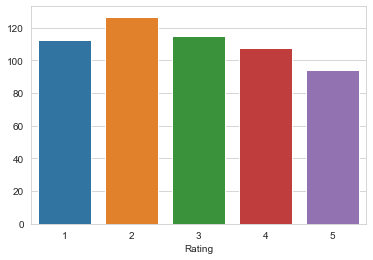

In [77]:
sns.barplot(x = grouped_rating.index, y = grouped_rating.values)

## Preprocessing

In [80]:
sw = stopwords.words('english')

In [78]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [81]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [ ]:
df['tokenized'] = df['Review'].apply(doc_preparer)

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'non', 'existent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'pay', 'parking', 'night']
['ok', 'nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', 'th', 'anniversary', 'seattle', 'start', 'booked', 'suite', 'paid', 'extra', 'website', 'description', 'suit